In [ ]:
## [Run one-time]
# import kagglehub

# path = kagglehub.dataset_download("ejlok1/cremad")
# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
# path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# print("Path to dataset files:", path)

In [ ]:
# # [Run one-time]
# import os

# dir_path = "/home/hice1/plin308/.cache/kagglehub/datasets"

# # Define renaming mapping
# dir_mapping = {
#     "ejlok1": "crema_d",
#     "uwrfkaggler": "ravdess",
#     "ejlok1": "tess"
# }

# # Rename directories
# for old_name, new_name in dir_mapping.items():
#     old_path = os.path.join(dir_path, old_name)
#     new_path = os.path.join(dir_path, new_name)
    
#     if os.path.exists(old_path):
#         os.rename(old_path, new_path)
#         print(f"Renamed: {old_path} -> {new_path}")
#     else:
#         print(f"Directory not found: {old_path}")


In [ ]:
# # [Run one-time]
# import os
# import shutil

# def move_wav_files(directory):
#     """
#     Moves all .wav files from subdirectories to the specified directory.
#     """
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.endswith(".wav"):
#                 source = os.path.join(root, file)
#                 destination = os.path.join(directory, file)
                
#                 # Avoid overwriting files by renaming if necessary
#                 if os.path.exists(destination):
#                     base, ext = os.path.splitext(file)
#                     counter = 1
#                     new_destination = os.path.join(directory, f"{base}_{counter}{ext}")
#                     while os.path.exists(new_destination):
#                         counter += 1
#                         new_destination = os.path.join(directory, f"{base}_{counter}{ext}")
#                     destination = new_destination
                
#                 shutil.move(source, destination)
#                 print(f"Moved: {source} -> {destination}")

# if __name__ == "__main__":
#     target_directories = [
#         "/home/hice1/plin308/.cache/kagglehub/datasets"
# #         "/home/hice1/plin308/.cache/kagglehub/datasets/crema_d",
# #         "/home/hice1/plin308/.cache/kagglehub/datasets/ravdess",
# #         "/home/hice1/plin308/.cache/kagglehub/datasets/tess",
#     ]
    
#     # Iterate over each directory in the list
#     for directory in target_directories:
#         move_wav_files(directory)


In [ ]:
import os
print(os.getcwd())

In [ ]:
# # [Run one-time]
# # install libraries
# !pip install torch torchaudio transformers librosa numpy pandas scikit-learn

In [ ]:
import os
import numpy as np
import torchaudio
import torch
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2FeatureExtractor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [7]:
## Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # option 1: uncomment if want to use GPU
# device = torch.device("cpu") # option 2: uncomment this if want to use cpu, not using gpu

# Data Examining

In [8]:
# # Load metadata
metadata = pd.read_csv("preprocessed_metadata.csv")

In [9]:
# # Using Merged Datasets

df = metadata

# count datapoints per emotion
df['emotion'].value_counts()

emotion
disgust      1863
sad          1863
happy        1863
fear         1671
neutral      1583
anger        1271
angry         592
surprised     592
fearful       192
calm          192
Name: count, dtype: int64

In [10]:
# Standadize the similar emotion type
df['emotion'] = df['emotion'].replace(['anger','fearful', 'ps', 'calm'], ['angry','fear', 'surprised', 'neutral'])

df = df[df['emotion'] != 'unknown']

df['emotion'].value_counts()

emotion
angry        1863
disgust      1863
sad          1863
fear         1863
happy        1863
neutral      1775
surprised     592
Name: count, dtype: int64

In [11]:
import glob
import os


base_path = "/home/hice1/plin308/.cache/kagglehub/datasets"

# Create a dictionary: {basename → full path}
all_files = glob.glob(os.path.join(base_path, "*.wav"))
basename_to_path = {os.path.basename(p): p for p in all_files}


df["filename"] = df["file_path"].apply(os.path.basename)

def find_full_path(filename):
    name_only = os.path.splitext(filename)[0]  # remove extension
    for base_name, full_path in basename_to_path.items():
        if base_name.startswith(name_only):  # loose match like abc == abc_1
            return full_path
    return None

df["full_path"] = df["filename"].apply(find_full_path)

print(df["full_path"][0])

/home/hice1/plin308/.cache/kagglehub/datasets/1022_ITS_ANG_XX.wav


In [12]:
# Prepare a dictionary to store splits
splits = {}

# Apply 80/10/10 split per dataset
for dataset_name in df['dataset'].unique():
    df_subset = df[df['dataset'] == dataset_name]

    # Step 1: Train/Test split (80/20)
    train, temp = train_test_split(df_subset, test_size=0.2, stratify=df_subset["emotion"], random_state=42)

    # Step 2: From the 20% temp, split half for val/test (10%/10%)
    val, test = train_test_split(temp, test_size=0.5, stratify=temp["emotion"], random_state=42)

    splits[dataset_name] = {
        "train": train.reset_index(drop=True),
        "val": val.reset_index(drop=True),
        "test": test.reset_index(drop=True)
    }

# ✅ Merge all training sets
train_df = pd.concat([splits[ds]["train"] for ds in splits]).reset_index(drop=True)

# ✅ Merge all validation and test sets
val_df_all = pd.concat([splits[ds]["val"] for ds in splits]).reset_index(drop=True)
test_df_all = pd.concat([splits[ds]["test"] for ds in splits]).reset_index(drop=True)

# Also keep per-dataset val/test for evaluation
val_df_dict = {ds: splits[ds]["val"] for ds in splits}
test_df_dict = {ds: splits[ds]["test"] for ds in splits}


print("Training data")
print(train_df['emotion'].value_counts())
print("Val data")
print(val_df_all['emotion'].value_counts())
print("Training data")
print(test_df_all['emotion'].value_counts())

Training data
emotion
angry        1491
disgust      1491
fear         1491
sad          1490
happy        1489
neutral      1419
surprised     474
Name: count, dtype: int64
Val data
emotion
sad          187
fear         186
angry        186
happy        186
disgust      186
neutral      178
surprised     59
Name: count, dtype: int64
Training data
emotion
happy        188
fear         186
disgust      186
angry        186
sad          186
neutral      178
surprised     59
Name: count, dtype: int64


In [13]:
test_df_all.head()


,file_path,emotion,dataset,filename,full_path
0,prepro_pad_trun_audio/crema_d/1033_WSI_FEA_XX.wav,fear,crema_d,1033_WSI_FEA_XX.wav,/home/hice1/plin308/.cache/kagglehub/datasets/...
1,prepro_pad_trun_audio/crema_d/1063_DFA_NEU_XX.wav,neutral,crema_d,1063_DFA_NEU_XX.wav,/home/hice1/plin308/.cache/kagglehub/datasets/...
2,prepro_pad_trun_audio/crema_d/1076_IWW_HAP_XX.wav,happy,crema_d,1076_IWW_HAP_XX.wav,/home/hice1/plin308/.cache/kagglehub/datasets/...
3,prepro_pad_trun_audio/crema_d/1059_TIE_DIS_XX.wav,disgust,crema_d,1059_TIE_DIS_XX.wav,/home/hice1/plin308/.cache/kagglehub/datasets/...
4,prepro_pad_trun_audio/crema_d/1074_IWW_ANG_XX.wav,angry,crema_d,1074_IWW_ANG_XX.wav,/home/hice1/plin308/.cache/kagglehub/datasets/...


In [14]:
# Define global vars

EMOTION_MAP = {
    "disgust": 0,
    "happy": 1,
    "sad": 2,
    "fear": 3,
    "neutral": 4,
    "angry": 5,
    "surprised": 6
}

NUM_LABELS = len(EMOTION_MAP)
BATCH_SIZE = 8
SAMPLE_RATE = 16000

print(NUM_LABELS)

7


In [17]:
class SERDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, sample_rate=16000):
        self.feature_extractor = feature_extractor
        self.sample_rate = sample_rate

        self.df = dataframe[dataframe["full_path"].apply(os.path.exists)].reset_index(drop=True)

        print(f"✅ Loaded {len(self.df)} audio files out of {len(dataframe)}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      full_path = row["full_path"]  # Use directly

      emotion = row["emotion"]
      label = torch.tensor(EMOTION_MAP[emotion])  

      waveform, sr = torchaudio.load(full_path)
      if waveform.shape[0] > 1:  # if stereo
         waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono

    
#       waveform, sr = torchaudio.load(full_path)
#       if sr != self.sample_rate:
#         waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

      inputs = self.feature_extractor(
          waveform.squeeze().numpy(),
          sampling_rate=self.sample_rate,
          return_tensors="pt",
          padding=True
      )

      return {
          "input_values": inputs.input_values.squeeze(0),
          "label": label  # Use the mapped torch tensor label
      }

    
    
def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    input_values_padded = torch.nn.utils.rnn.pad_sequence(
        input_values, batch_first=True
    )
    return {
        "input_values": input_values_padded,
        "label": labels
    }

# # Create functions for padding of audio
# def collate_fn(batch):
#     input_values = [item["input_values"] for item in batch]
#     labels = torch.tensor([item["label"] for item in batch])

#     # Pad audio inputs to the same length
#     input_values_padded = torch.nn.utils.rnn.pad_sequence(
#         input_values, batch_first=True
#     )

#     return {
#         "input_values": input_values_padded,
#         "label": labels
#     }


In [18]:
from sklearn.model_selection import train_test_split

# Train/Val/Test split
## Train/ (Val/Test)split
# train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["emotion"],random_state=42)

## Val/Test
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["emotion"],random_state=42)

# ## Reset indices
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["emotion"], random_state=42)


# Load feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")

# Dataset
train_dataset = SERDataset(train_df, feature_extractor)
val_dataset = SERDataset(val_df_all, feature_extractor)
test_dataset = SERDataset(test_df_all, feature_extractor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

✅ Loaded 9345 audio files out of 9345
✅ Loaded 1168 audio files out of 1168
✅ Loaded 1169 audio files out of 1169


In [19]:
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 9345, Test samples: 1169


# Adding Classification Head to Wav2Vec 2.0




In [20]:
# !pip install datasets soundfile


In [21]:
class Wav2Vec2EmotionClassifier(nn.Module):
    def __init__(self, num_labels=7):
        super(Wav2Vec2EmotionClassifier, self).__init__()

        # Load the base Wav2Vec 2.0 model (frozen or trainable)
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53")

        # [update]Freeze all wav2vec2 layers first
        for param in self.wav2vec2.parameters():
            param.requires_grad = False

        
        # [default]simplest classificatoin head
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_labels)


    def forward(self, input_values, attention_mask=None):
        # Extract audio embeddings
        outputs = self.wav2vec2(input_values=input_values, attention_mask=attention_mask)

        # Get hidden states: (batch_size, time_steps, hidden_size)
        hidden_states = outputs.last_hidden_state

        # Mean pooling over time dimension
        pooled = hidden_states.mean(dim=1)  # (batch_size, hidden_size)

        # Pass through classification head
        logits = self.classifier(pooled)

        return logits


In [22]:
from torch.optim.lr_scheduler import StepLR

# create model instance - Base w2v with my added classification head
model_base_w2v_add_classification_head = Wav2Vec2EmotionClassifier(num_labels=NUM_LABELS)
model_base_w2v_add_classification_head.to(device)

# define optimizer
optimizer = AdamW(model_base_w2v_add_classification_head.parameters(), lr=1e-5) #Old
# optimizer = AdamW(model_base_w2v_add_classification_head.parameters(), lr=1e-5, weight_decay=0.01) # Optimized

# Reduce LR every 2 epochs by half
# scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


# define epochs
EPOCHS = 5

In [23]:
for name, param in model_base_w2v_add_classification_head.named_parameters():
    if param.requires_grad:
        print(f"Training: {name}")

Training: classifier.weight
Training: classifier.bias


In [ ]:
### TRAIN MODELS
for epoch in range(EPOCHS):
    model_base_w2v_add_classification_head.train()
    total_loss = 0
    for batch in train_loader:
        input_values = batch["input_values"].to(device)
        labels = batch["label"].to(device)

        logits = model_base_w2v_add_classification_head(input_values)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

#     print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
#     current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")
#     print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | LR: {current_lr:.2e}")

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Put model in eval mode
model_base_w2v_add_classification_head.eval()

In [ ]:
# Track predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_values = batch["input_values"].to(device)
        labels = batch["label"].to(device)

        logits = model_base_w2v_add_classification_head(input_values)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
y_true = all_labels
y_pred = all_preds



In [ ]:
# ✅ Metrics
acc = accuracy_score(y_true, y_pred)
uar = recall_score(y_true, y_pred, average="macro")
recall_weighted = recall_score(y_true, y_pred, average="weighted")
f1_weighted = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)

# ✅ Print metrics
print(f"\n🎯 Evaluation Metrics:")
print(f"Accuracy:               {acc:.4f}")
print(f"Unweighted Avg Recall:  {uar:.4f}")
print(f"Weighted Recall:        {recall_weighted:.4f}")
print(f"Weighted F1 Score:      {f1_weighted:.4f}")
print(f"Cohen's Kappa:          {kappa:.4f}")

In [ ]:

# ✅ Classification report (optional)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTION_MAP.keys()))
# print(classification_report(y_true, y_pred))

# ✅ Confusion Matrix (optional)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=EMOTION_MAP.keys())
disp.plot(xticks_rotation=45)


In [ ]:
# Save model
import os
os.makedirs("saved_models", exist_ok=True)

torch.save(model_base_w2v_add_classification_head.state_dict(), "saved_models/w2v_added_classification_head_weights_15042025_2.pth") 





## QLoRA

In [ ]:
## [Run one-time]
# !pip install peft bitsandbytes accelerate

In [24]:
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
import glob
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
from peft import LoraConfig, get_peft_model
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler
import time
import pickle
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR
from transformers import BitsAndBytesConfig

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Preprocess and save features
def preprocess_and_save_features(df, feature_extractor, sample_rate=16000, max_duration=5.0, cache_dir="features_cache"):
    os.makedirs(cache_dir, exist_ok=True)
    max_length = int(max_duration * sample_rate)
    feature_files = []
    
    for idx, row in df.iterrows():
        full_path = row["full_path"]
        if not os.path.exists(full_path):
            continue
        cache_path = os.path.join(cache_dir, f"feature_{idx}.pkl")
        if os.path.exists(cache_path):
            feature_files.append(cache_path)
            continue
        
        waveform, sr = torchaudio.load(full_path)
        if sr != sample_rate:
            waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        current_length = waveform.shape[1]
        if current_length > max_length:
            waveform = waveform[:, :max_length]
        else:
            padding = max_length - current_length
            waveform = F.pad(waveform, (0, padding), mode='constant', value=0)
        
        inputs = feature_extractor(
            waveform.squeeze().numpy(),
            sampling_rate=sample_rate,
            return_tensors="pt",
            padding=True
        )
        
        input_values = inputs.input_values.squeeze(0)
        if torch.isnan(input_values).any() or torch.isinf(input_values).any():
            print(f"Warning: Invalid input values in file {full_path}")
            input_values = torch.zeros_like(input_values)
        
        with open(cache_path, 'wb') as f:
            pickle.dump(input_values, f)
        feature_files.append(cache_path)
    
    return feature_files


In [26]:
# # Load metadata
# metadata = pd.read_csv("preprocessed_metadata.csv")
# df = metadata

# # Standardize emotion types
# df['emotion'] = df['emotion'].replace(['anger', 'fearful', 'ps', 'calm'], ['angry', 'fear', 'surprised', 'neutral'])
# df = df[df['emotion'] != 'unknown']
# df['emotion'].value_counts()


# # Map filenames to full paths
# base_path = "/home/hice1/plin308/.cache/kagglehub/datasets"
# all_files = glob.glob(os.path.join(base_path, "*.wav"))
# basename_to_path = {os.path.basename(p): p for p in all_files}

# df["filename"] = df["file_path"].apply(os.path.basename)

# def find_full_path(filename):
#     name_only = os.path.splitext(filename)[0]
#     for base_name, full_path in basename_to_path.items():
#         if base_name.startswith(name_only):
#             return full_path
#     return None

# df["full_path"] = df["filename"].apply(find_full_path)


# df.head()



In [27]:
# df1 = df[df['dataset'] == 'crema_d']

# df = df1

# len(df)

In [28]:
# Define global variables
EMOTION_MAP = {
    "disgust": 0,
    "happy": 1,
    "sad": 2,
    "fear": 3,
    "neutral": 4,
    "angry": 5,
    "surprised": 6
}




NUM_LABELS = len(EMOTION_MAP)
BATCH_SIZE = 8
EPOCHS = 10

LORA_RANK=8
LORA_ALPHA=16



In [29]:
# # Compute class weights
class_counts = df['emotion'].value_counts()
class_weights = torch.tensor(
    [1.0 / class_counts.get(emo, 1.0) for emo in EMOTION_MAP.keys()],
    dtype=torch.float32
).to(device)
class_weights = torch.clamp(class_weights, min=0.5, max=3.0)
class_weights = class_weights / class_weights.sum() * NUM_LABELS

In [ ]:
# # Train/Val/Test split
# ## Train/ (Val/Test)split
# train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["emotion"],random_state=42)

# ## Val/Test
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["emotion"],random_state=42)

# # ## Reset indices
# # train_df = train_df.reset_index(drop=True)
# # val_df = val_df.reset_index(drop=True)
# # test_df = test_df.reset_index(drop=True)

# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")



# # [Run one-time]: Precompute features
print("Precomputing features...")
SAMPLE_RATE=16000
MAX_DURATION=5.0
train_feature_files = preprocess_and_save_features(train_df, feature_extractor, SAMPLE_RATE, MAX_DURATION, "features_cache01/train")
val_feature_files = preprocess_and_save_features(val_df_all, feature_extractor, SAMPLE_RATE, MAX_DURATION, "features_cache01/val")
test_feature_files = preprocess_and_save_features(test_df_all, feature_extractor, SAMPLE_RATE, MAX_DURATION, "features_cache01/test")

print("Done")


In [32]:
# # Load cached feature files
# def load_feature_files(cache_dir, df):
#     feature_files = []
#     for idx in df.index:
#         cache_path = os.path.join(cache_dir, f"feature_{idx}.pkl")
#         if os.path.exists(cache_path):
#             feature_files.append(cache_path)
#         else:
#             print(f"Warning: Missing feature file {cache_path}")
#     return feature_files

# print("Loading cached features...")
# train_feature_files = load_feature_files("features_cache01/train", train_df)
# test_feature_files = load_feature_files("features_cache01/test", test_df_all)
# print(f"Loaded {len(train_feature_files)} training features and {len(test_feature_files)} testing features")

Loading cached features...
Loaded 9345 training features and 1169 testing features


In [ ]:
# # Dataset class
# class SERDataset(Dataset):
#     def __init__(self, feature_files, df):
#         self.feature_files = feature_files
#         self.df = df.reset_index(drop=True)
#         print(f"✅ Loaded {len(self.feature_files)} features for {len(self.df)} samples")

#     def __len__(self):
#         return len(self.feature_files)

#     def __getitem__(self, idx):
#         with open(self.feature_files[idx], 'rb') as f:
#             input_values = pickle.load(f)
#         input_values = input_values.to(dtype=torch.float16)  # Cast to float16
#         emotion = self.df.iloc[idx]["emotion"]
#         label = torch.tensor(EMOTION_MAP[emotion], dtype=torch.long)
#         return {
#             "input_values": input_values,
#             "label": label
#         }

# # Collate function
# def collate_fn(batch):
#     input_values = [item["input_values"] for item in batch]
#     labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
#     input_values_padded = torch.nn.utils.rnn.pad_sequence(
#         input_values, batch_first=True
#     )
#     return {
#         "input_values": input_values_padded,
#         "label": labels
#     }

# # Data loaders
# train_dataset = SERDataset(train_feature_files, train_df)
# test_dataset = SERDataset(test_feature_files, test_df)
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     collate_fn=collate_fn,
#     num_workers=4,
#     pin_memory=True
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=4,
#     pin_memory=True
# )

In [33]:
# Wav2Vec2EmotionClassifier
class Wav2Vec2EmotionClassifier(nn.Module):
    def __init__(self, num_labels=7, num_unfrozen_layers=0):
        super(Wav2Vec2EmotionClassifier, self).__init__()
        
        #[QLoRA]: quantized (4-bit/8-bit) pretrained weights.
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(
            "facebook/wav2vec2-large-xlsr-53",
            quantization_config=BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True
            ),
            torch_dtype=torch.float16
        )
        for param in self.wav2vec2.parameters():
            param.requires_grad = False
        
        # [LoRA] Config.
        lora_config = LoraConfig(
            r=LORA_RANK,
            lora_alpha=LORA_ALPHA,
            target_modules=["q_proj", "v_proj", "k_proj"], #all-linear
            lora_dropout=0.2,
            bias="none"
        )
        self.wav2vec2 = get_peft_model(self.wav2vec2, lora_config)
        
        
       # [Default]simplest classificatoin head
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_labels)
        
        # [NN] Use pre-QLoRA classification head
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(self.wav2vec2.config.hidden_size, eps=1e-5),
#             nn.Linear(self.wav2vec2.config.hidden_size, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels)
#         )
        self.classifier.to(dtype=torch.float32)
    
        # Print trainable parameters
        print("Trainable parameters:")
        trainable_params = 0
        for n, p in self.named_parameters():
            if p.requires_grad:
                print(n)
                trainable_params += p.numel()
        print(f"Total trainable parameters: {trainable_params}")

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values=input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        pooled = hidden_states.mean(dim=1)
        if torch.isnan(pooled).any() or torch.isinf(pooled).any():
            print("Warning: NaN or Inf detected in pooled output")
            pooled = torch.nan_to_num(pooled, nan=0.0, posinf=0.0, neginf=0.0)
        pooled = pooled.to(torch.float32)
        logits = self.classifier(pooled)
        return logits
    
    
# class WarmupStepScheduler:
#     def __init__(self, optimizer, warmup_steps, lr_start=3e-5, lr_max=5e-5, decay_factor=0.5):
#         self.optimizer = optimizer
#         self.warmup_steps = warmup_steps
#         self.lr_start = lr_start
#         self.lr_max = lr_max
#         self.decay_factor = decay_factor
#         self.current_step = 0
#         for param_group in self.optimizer.param_groups:
#             param_group['lr'] = lr_start

#     def step(self):
#         self.current_step += 1
#         if self.current_step <= self.warmup_steps:
#             lr = self.lr_start + (self.lr_max - self.lr_start) * (self.current_step / self.warmup_steps)
#         else:
#             steps_after_warmup = self.current_step - self.warmup_steps
#             lr = self.lr_max * (self.decay_factor ** (steps_after_warmup // self.warmup_steps))
#         for param_group in self.optimizer.param_groups:
#             param_group['lr'] = lr
        
#     def get_last_lr(self):
#         return [group['lr'] for group in self.optimizer.param_groups]



In [34]:
# Validation function
def validate(model, val_loader, class_weights):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            input_values = batch["input_values"].to(device)
            labels = batch["label"].to(device)
            with autocast('cuda'):
                logits = model(input_values)
                loss = F.cross_entropy(logits, labels, weight=class_weights)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# Train and evaluate
def train_and_evaluate(model_name, num_unfrozen_layers, model_save_path):
    print(f"\nTraining model: {model_name} (Unfrozen Layers: {num_unfrozen_layers})...")
    model = Wav2Vec2EmotionClassifier(num_labels=NUM_LABELS, num_unfrozen_layers=num_unfrozen_layers)
    model.to(device)
    
    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr_0,
        weight_decay=1e-3
    )
    
    scheduler = StepLR(optimizer, step_size=2, gamma=gamma)
    
    # Class-weighted loss
    class_counts = train_df["emotion"].value_counts().reindex(EMOTION_MAP.keys())
    class_weights = torch.tensor([1.0 / class_counts.get(emo, 1.0) for emo in EMOTION_MAP.keys()], dtype=torch.float32).to(device)
    class_weights = torch.clamp(class_weights, min=0.5, max=2.0)
    class_weights = class_weights / class_weights.sum() * NUM_LABELS
    
    scaler = GradScaler('cuda')
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    val_loss_history = []

    model.train()
    for epoch in range(EPOCHS):
        start_time = time.time()
        total_loss = 0
        num_batches = 0
        all_preds = []
        all_labels = []
        
        for batch in train_loader:
            input_values = batch["input_values"].to(device)
            labels = batch["label"].to(device)
            
            optimizer.zero_grad()
            with autocast('cuda'):
                logits = model(input_values)
                loss = F.cross_entropy(logits, labels, weight=class_weights)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: NaN or Inf loss detected in batch")
                continue
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            num_batches += 1
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / num_batches
        val_loss = validate(model, test_loader, class_weights)
        current_lr = scheduler.get_last_lr()[0]
        epoch_time = time.time() - start_time
        
        val_loss_history.append(val_loss)
        if len(val_loss_history) > 2:
            val_loss_history.pop(0)
        smoothed_val_loss = sum(val_loss_history) / len(val_loss_history)
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Smoothed Val Loss: {smoothed_val_loss:.4f} | LR: {current_lr:.2e} | Time: {epoch_time:.2f}s")
        
        if smoothed_val_loss < best_val_loss:
            best_val_loss = smoothed_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path + ".best")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        scheduler.step()
    
#     model.load_state_dict(torch.load(model_save_path + ".best")) # bug
    model.load_state_dict(torch.load(model_save_path + ".best"), strict=False)


    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_values = batch["input_values"].to(device)
            labels = batch["label"].to(device)
            with autocast('cuda'):
                logits = model(input_values)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    acc = accuracy_score(y_true, y_pred)
    uar = recall_score(y_true, y_pred, average="macro")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    kappa = cohen_kappa_score(y_true, y_pred)
    
    print(f"\n🎯 Evaluation Metrics ({model_name}):")
    print(f"Accuracy:               {acc:.4f}")
    print(f"Unweighted Avg Recall:  {uar:.4f}")
    print(f"Weighted Recall:        {recall_weighted:.4f}")
    print(f"Weighted F1 Score:      {f1_weighted:.4f}")
    print(f"Cohen's Kappa:          {kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=EMOTION_MAP.keys()))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=EMOTION_MAP.keys())
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix ({model_name})")
#     plt.savefig(f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png")
#     plt.close()
    
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")


`low_cpu_mem_usage` was None, now default to True since model is quantized.



Training model: QLoRA 2 Unfrozen Layer (Unfrozen Layers: 1)...
Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.bas

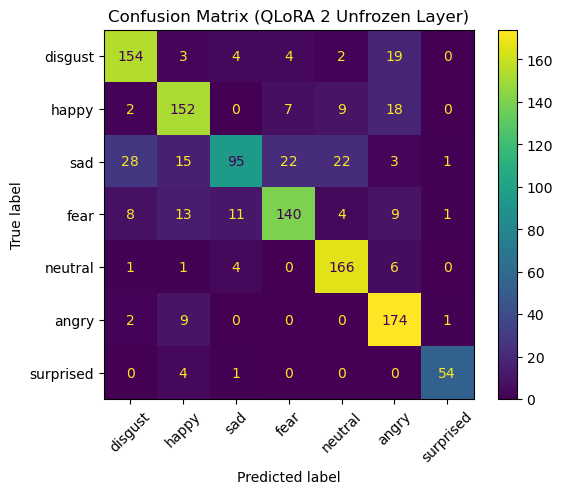

In [43]:
#Try 1:
gamma=0.5
lr_0=5e-4   # weight_decay=1e-3
# Train model
train_and_evaluate(
    model_name="QLoRA 2 Unfrozen Layer",
    num_unfrozen_layers=1,
    model_save_path="saved_models/w2v_qlora_t1_default.pth"
)


`low_cpu_mem_usage` was None, now default to True since model is quantized.



Training model: QLoRA 2 Unfrozen Layer (Unfrozen Layers: 1)...
Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.bas

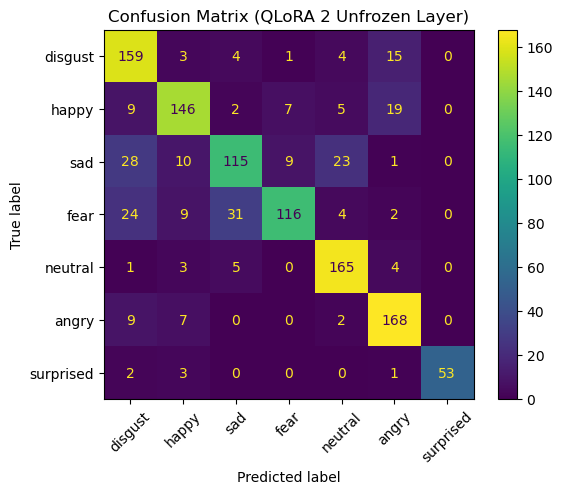

In [40]:
#Try 2:
gamma=0.6
lr_0=5e-4   # weight_decay=1e-3
# Train model
train_and_evaluate(
    model_name="QLoRA 2 Unfrozen Layer",
    num_unfrozen_layers=1,
    model_save_path="saved_models/w2v_qlora_t2_default.pth"
)



Training model: QLoRA 2 Unfrozen Layer (Unfrozen Layers: 1)...


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_B.default.w

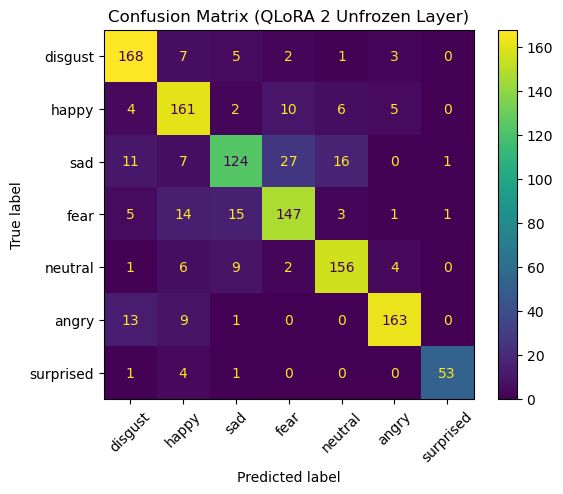

In [44]:
#Try 4:
gamma=0.5
lr_0=6e-4   # weight_decay=1e-3
# Train model
train_and_evaluate(
    model_name="QLoRA 2 Unfrozen Layer",
    num_unfrozen_layers=1,
    model_save_path="saved_models/w2v_qlora_t4_default.pth"
)


`low_cpu_mem_usage` was None, now default to True since model is quantized.



Training model: QLoRA 2 Unfrozen Layer (Unfrozen Layers: 1)...
Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.bas

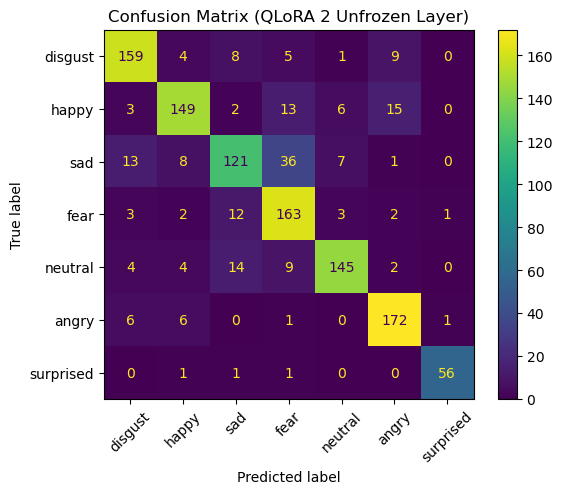

In [52]:
#Try 5:
gamma=0.6
lr_0=6e-4   # weight_decay=1e-3
# Train model
train_and_evaluate(
    model_name="QLoRA 2 Unfrozen Layer",
    num_unfrozen_layers=1,
    model_save_path="saved_models/w2v_qlora_t5_default.pth"
)


In [46]:
from datetime import datetime

now = datetime.now()
print("Current time:", now)

Current time: 2025-04-28 03:18:17.239703


In [37]:
# Dataset
train_dataset = SERDataset(train_df, feature_extractor)
val_dataset = SERDataset(val_df_all, feature_extractor)
test_dataset = SERDataset(test_df_all, feature_extractor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


✅ Loaded 9345 audio files out of 9345
✅ Loaded 1168 audio files out of 1168
✅ Loaded 1169 audio files out of 1169


In [38]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
import torch.nn.functional as F
import numpy as np

def evaluate_all_datasets(model, test_df_dict, test_df_all, feature_extractor, batch_size=8):
    model.eval()

    def get_loader(df):
        dataset = SERDataset(df, feature_extractor)
        return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    # === Combined Test Set Evaluation ===
    loader_all = get_loader(test_df_all)
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader_all:
            input_values = batch["input_values"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_values)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader_all)
    accuracy_all = accuracy_score(all_labels, all_preds)
    f1_all = f1_score(all_labels, all_preds, average="macro")

    print(f"\n📊 Combined Test Set")
    print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy_all:.2%} | F1 Score: {f1_all:.2%}")

    # === Per Dataset Evaluation ===
    dataset_accuracies = {}

    for ds_name, df in test_df_dict.items():
        loader = get_loader(df)
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in loader:
                input_values = batch["input_values"].to(device)
                labels = batch["label"].to(device)

                logits = model(input_values)
                preds = torch.argmax(logits, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        dataset_accuracies[ds_name] = acc

        print(f"🧪 {ds_name.upper()} Accuracy: {acc:.2%}")

    return {
        "combined": {
            "accuracy": accuracy_all,
            "f1": f1_all,
            "loss": avg_loss
        },
        "per_dataset_accuracy": dataset_accuracies
    }


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, test_df_all, feature_extractor, batch_size=8, normalize=True, plot=True):
    """
    Generate and optionally plot the confusion matrix on the combined test set.

    Args:
        model: Trained model.
        test_df_all: DataFrame with the combined test set.
        feature_extractor: HuggingFace audio processor.
        batch_size: Batch size for DataLoader.
        normalize (bool): Normalize rows to percentages.
        plot (bool): Whether to display the matrix plot.

    Returns:
        conf_mat: (Normalized) confusion matrix (as numpy array).
    """
    model.eval()

    # Create DataLoader
    dataset = SERDataset(test_df_all, feature_extractor)
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            input_values = batch["input_values"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_values)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(EMOTION_MAP.values()))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    if plot:
        emotion_labels = list(EMOTION_MAP.keys())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                    xticklabels=emotion_labels, yticklabels=emotion_labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix (Normalized)" if normalize else "Confusion Matrix")
        plt.show()

    return cm



def get_confusion_matrix_per_dataset(model, test_df_dict, feature_extractor, batch_size=8, normalize=True, plot=True):
    """
    Generate and optionally plot confusion matrices for each dataset separately.

    Args:
        model: Trained model.
        test_df_dict: Dict of test DataFrames per dataset (e.g., {"crema_d": df1, "ravdess": df2, ...}).
        feature_extractor: HuggingFace audio processor.
        batch_size: Batch size for DataLoader.
        normalize (bool): Normalize rows to percentages.
        plot (bool): Whether to display the matrix plots.

    Returns:
        confusion_matrices: dict mapping dataset name to its confusion matrix.
    """
    model.eval()
    confusion_matrices = {}

    for ds_name, df in test_df_dict.items():
        dataset = SERDataset(df, feature_extractor)
        loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in loader:
                input_values = batch["input_values"].to(device)
                labels = batch["label"].to(device)

                logits = model(input_values)
                preds = torch.argmax(logits, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred, labels=list(EMOTION_MAP.values()))

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        confusion_matrices[ds_name] = cm

        if plot:
            emotion_labels = list(EMOTION_MAP.keys())
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                        xticklabels=emotion_labels, yticklabels=emotion_labels)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(f"{ds_name.upper()} Confusion Matrix (Normalized)" if normalize else f"{ds_name.upper()} Confusion Matrix")
            plt.show()

    return confusion_matrices


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_B.default.w

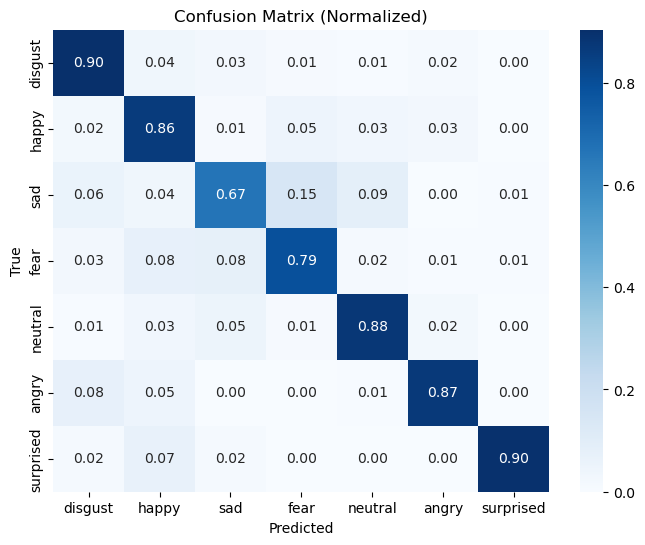

✅ Loaded 1169 audio files out of 1169


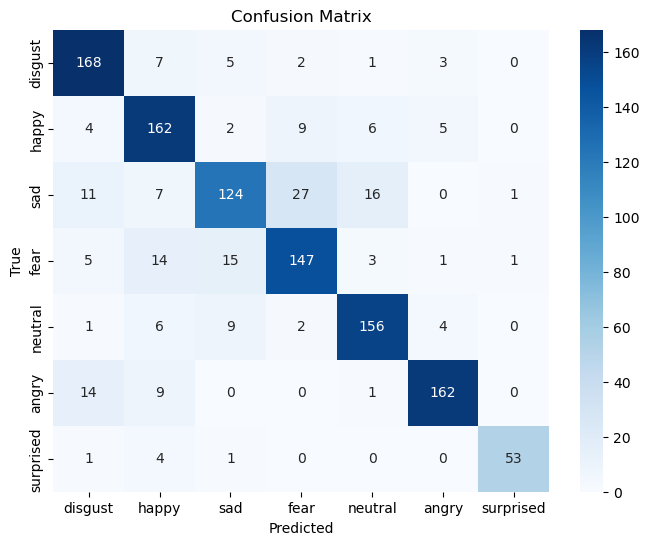

In [47]:
model = Wav2Vec2EmotionClassifier(num_labels=NUM_LABELS, num_unfrozen_layers=0)
model = model.to(device)

state_dict = torch.load("saved_models/w2v_qlora_t4_default.pth", map_location=device)
# model.load_state_dict(state_dict)
model.load_state_dict(state_dict, strict=False)

model = model.to(device)
model = model.float()
model.eval()


results = evaluate_all_datasets(
    model,
    test_df_dict=test_df_dict,
    test_df_all=test_df_all,
    feature_extractor=feature_extractor
)

conf_matrix = get_confusion_matrix(model, test_df_all, feature_extractor)
conf_matrix = get_confusion_matrix(model, test_df_all, feature_extractor, normalize=False)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Trainable parameters:
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.0.attention.q_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.k_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.v_proj.lora_B.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_A.default.weight
wav2vec2.base_model.model.encoder.layers.1.attention.q_proj.lora_B.default.w

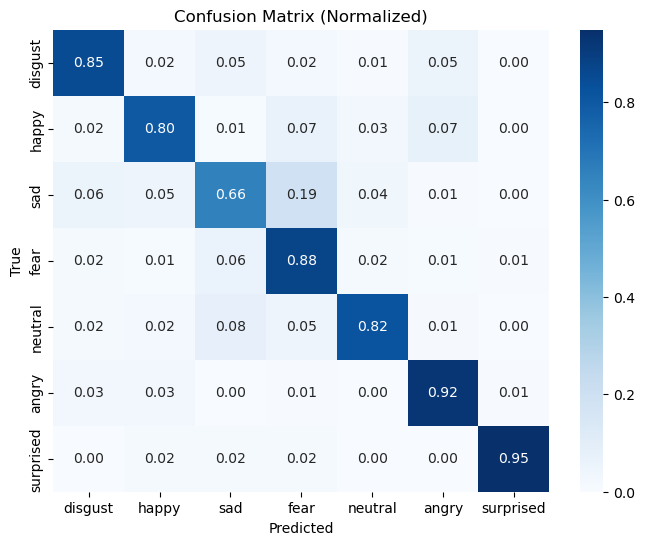

✅ Loaded 1169 audio files out of 1169


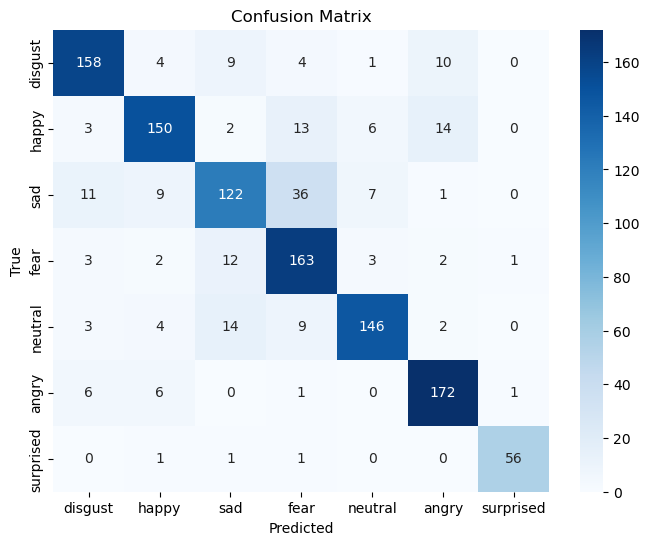

In [53]:
model = Wav2Vec2EmotionClassifier(num_labels=NUM_LABELS, num_unfrozen_layers=0)
model = model.to(device)

state_dict = torch.load("saved_models/w2v_qlora_t5_default.pth", map_location=device)
# model.load_state_dict(state_dict)
model.load_state_dict(state_dict, strict=False)

model = model.to(device)
model = model.float()
model.eval()


results = evaluate_all_datasets(
    model,
    test_df_dict=test_df_dict,
    test_df_all=test_df_all,
    feature_extractor=feature_extractor
)

conf_matrix = get_confusion_matrix(model, test_df_all, feature_extractor)
conf_matrix = get_confusion_matrix(model, test_df_all, feature_extractor, normalize=False)